In [60]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t

In [61]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import yaml
with open('config.yaml', 'r') as file:
    token = yaml.safe_load(file)['token']

import tushare as ts
pro = ts.pro_api(token)

In [62]:
future_list = pro.fut_basic(fut_type = 2)
future_list

,ts_code,symbol,exchange,name,fut_code,multiplier,trade_unit,per_unit,quote_unit,quote_unit_desc,d_mode_desc,list_date,delist_date,d_month,last_ddate
0,CFE_LL161MSF.WI,CFE_LL161MSF,None,上证50当月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
1,CFE_LL161QSF.WI,CFE_LL161QSF,None,上证50当季合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
2,CFE_LL162MSF.WI,CFE_LL162MSF,None,上证50下月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
3,CFE_LL162QSF.WI,CFE_LL162QSF,None,上证50下季合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
4,CFE_LL163MSF.WI,CFE_LL163MSF,None,上证50下下月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,IML3.CFX,IML3,CFFEX,中证1000期货下季连续,IM,None,None,None,None,None,None,None,None,None,None
207,TLL.CFX,TLL,CFFEX,30年期国债期货当季连续,TL,None,None,None,None,None,None,None,None,None,None
208,TLL1.CFX,TLL1,CFFEX,30年期国债期货下季连续,TL,None,None,None,None,None,None,None,None,None,None
209,TLL2.CFX,TLL2,CFFEX,30年期国债期货隔季连续,TL,None,None,None,None,None,None,None,None,None,None


In [63]:
start_date = '20170901'
end_date = '20230901'
data = pro.fut_daily(ts_code = 'IF.CFX')
data = data[data['trade_date'] > start_date].copy()
data = data[data['trade_date'] < end_date].copy()
data

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
507,IF.CFX,20230831,3794.0,3799.2,3798.0,3805.0,3767.4,3776.8,3776.4,-22.4,-22.8,64186.0,7.284642e+06,174717.0,None
508,IF.CFX,20230830,3796.4,3799.2,3810.0,3825.4,3788.0,3794.0,3799.2,-5.2,0.0,72711.0,8.300279e+06,174542.0,None
509,IF.CFX,20230829,3757.2,3758.8,3757.4,3829.0,3756.0,3796.4,3799.2,37.6,40.4,111720.0,1.271468e+07,183377.0,None
510,IF.CFX,20230828,3720.6,3716.4,3922.0,3930.0,3743.8,3757.2,3758.8,40.8,42.4,143924.0,1.649474e+07,200016.0,None
511,IF.CFX,20230825,3730.0,3735.8,3710.0,3749.0,3703.6,3720.6,3716.4,-15.2,-19.4,87238.0,9.737761e+06,187172.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,IF.CFX,20170908,3828.2,3836.2,3835.6,3847.0,3808.0,3820.8,3819.0,-15.4,-17.2,12189.0,1.400873e+06,24698.0,None
1960,IF.CFX,20170907,3846.6,3851.2,3853.0,3865.0,3828.0,3828.2,3836.2,-23.0,-15.0,11916.0,1.375113e+06,26322.0,None
1961,IF.CFX,20170906,3854.2,3858.0,3847.0,3862.4,3831.0,3846.6,3851.2,-11.4,-6.8,12015.0,1.386579e+06,27104.0,None
1962,IF.CFX,20170905,3842.6,3836.2,3847.2,3867.0,3841.2,3854.2,3858.0,18.0,21.8,11445.0,1.323342e+06,28187.0,None


In [64]:
data = pro.fut_daily(ts_code = 'TL1.CFX')
data = data[data['trade_date'] > start_date].copy()
data = data[data['trade_date'] < end_date].copy()
data

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
507,TL1.CFX,20230831,102.405,102.415,102.440,102.470,102.370,102.415,102.420,0.000,0.005,58849.0,6027124.145,176043.0,None
508,TL1.CFX,20230830,102.295,102.285,102.285,102.470,102.240,102.405,102.415,0.120,0.130,70239.0,7191632.900,177380.0,None
509,TL1.CFX,20230829,102.445,102.420,102.410,102.450,102.195,102.295,102.285,-0.125,-0.135,83297.0,8521219.440,173020.0,None
510,TL1.CFX,20230828,102.500,102.530,102.180,102.450,102.165,102.445,102.420,-0.085,-0.110,78896.0,8073969.575,173168.0,None
511,TL1.CFX,20230825,102.665,102.655,102.680,102.695,102.465,102.500,102.530,-0.155,-0.125,67141.0,6886702.225,172317.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,TL1.CFX,20170908,94.995,94.910,95.130,95.260,95.030,95.155,95.165,0.245,0.255,38237.0,3637698.310,63968.0,None
1960,TL1.CFX,20170907,94.710,94.710,94.715,95.010,94.695,94.995,94.910,0.285,0.200,35339.0,3351358.915,62909.0,None
1961,TL1.CFX,20170906,94.495,94.540,94.570,94.740,94.550,94.710,94.710,0.170,0.170,32073.0,3035557.845,60794.0,None
1962,TL1.CFX,20170905,94.695,94.740,94.670,94.680,94.495,94.495,94.540,-0.245,-0.200,32628.0,3086061.320,62119.0,None


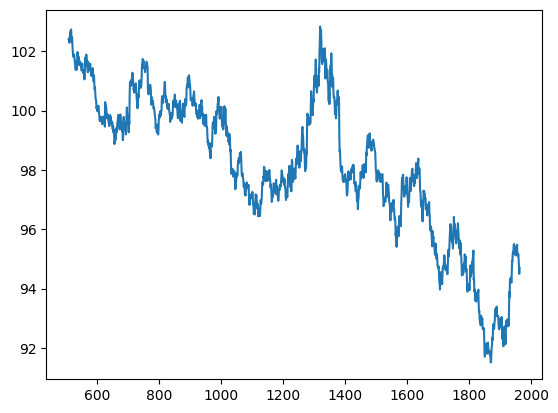

In [65]:
import matplotlib.pyplot as plt
plt.plot(data['close'])
plt.show()

In [66]:
# assets_list = []
# assets_names = []
# for i in future_list.index:
#     assets_code = future_list.loc[i, 'ts_code']
#     assets_name = future_list.loc[i, 'name']

#     if "主力" not in assets_name:
#         continue

#     data = pro.fut_daily(ts_code = assets_code)
#     data_head = data.head(100)

#     if len(data) < 1000:
#         continue
#     if data_head['oi'].mean() < 50000:
#         continue
#     assets_list.append(assets_code)
#     assets_names.append(assets_name)

# len(assets_list)

In [67]:
assets_list = [
    # 股指期货
    'IH.CFX', 'IF.CFX', 'IC.CFX',
    # 国债期货
    'TS.CFX', 'TF.CFX', 'T.CFX', 'TL1.CFX',
    # 黑色金属产业链
    'I.DCE', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'SS.SHF', 'SF.ZCE', 'SM.ZCE',
    # 有色金属
    'CU.SHF', 'AL.SHF', 'ZN.SHF', 'NI.SHF',
    # 贵金属
    'AU.SHF', 'AG.SHF',
    # 能源化工
    'FU.SHF', 'LU.INE', 'BU.SHF', 'PG.DCE', 'TA.ZCE', 'EG.DCE', 'PF.ZCE', 
    'L.DCE', 'PP.DCE', 'V.DCE', 'EB.DCE', 'MA.ZCE', 'UR.ZCE', 'RU.SHF',
    # 农产品
    'A.DCE', 'B.DCE', 'M.DCE', 'RM.ZCE', 'Y.DCE', 'OI.ZCE', 'P.DCE', 'PK.ZCE',
    'C.DCE', 'CS.DCE', 'CF.ZCE', 'SR.ZCE', 'CJ.ZCE', 'AP.ZCE', 'SP.SHF', 
    'JD.DCE', 'LH.DCE',
    # 建材
    'FG.ZCE', 'SA.ZCE'
]

In [68]:
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]

In [69]:
data = pro.fut_daily(ts_code = 'SF.ZCE', start_date = '20100101', end_date = '20180101')
data

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
0,SF.ZCE,20171229,6486.0,6582.0,6564.0,6600.0,6464.0,6510.0,6516.0,-72.0,-66.0,383334.0,1248637.68,197974.0,None
1,SF.ZCE,20171228,6802.0,6788.0,6790.0,6818.0,6408.0,6486.0,6582.0,-302.0,-206.0,582068.0,1915587.69,218316.0,None
2,SF.ZCE,20171227,6748.0,6760.0,6758.0,6844.0,6722.0,6802.0,6788.0,42.0,28.0,296112.0,1004966.51,161508.0,None
3,SF.ZCE,20171226,6722.0,6858.0,6698.0,6818.0,6686.0,6748.0,6760.0,-110.0,-98.0,227316.0,768183.02,139316.0,None
4,SF.ZCE,20171225,7080.0,7152.0,7010.0,7046.0,6722.0,6722.0,6858.0,-430.0,-294.0,341486.0,1170755.54,160692.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,SF.ZCE,20140814,5926.0,5910.0,5918.0,5936.0,5710.0,5740.0,5784.0,-170.0,-126.0,142708.0,412681.57,35404.0,None
826,SF.ZCE,20140813,5912.0,5906.0,5920.0,5946.0,5880.0,5926.0,5910.0,20.0,4.0,119328.0,352601.60,46610.0,None
827,SF.ZCE,20140812,5832.0,5838.0,5810.0,5956.0,5808.0,5912.0,5906.0,74.0,68.0,233812.0,690489.88,46588.0,None
828,SF.ZCE,20140811,5804.0,5796.0,5768.0,5882.0,5768.0,5832.0,5838.0,36.0,42.0,106956.0,312177.62,33658.0,None


In [70]:
pred_len = 5
threshold_ratio = 0.26

In [71]:
for asset_code in assets_list:

    data_1 = pro.fut_daily(ts_code = asset_code, start_date = '20100101', end_date = '20180101', fields = 'ts_code,trade_date,pre_close,open,high,low,close,vol')
    data_2 = pro.fut_daily(ts_code = asset_code, start_date = '20180101', fields = 'ts_code,trade_date,pre_close,open,high,low,close,vol')
    data = pd.concat([data_1, data_2], ignore_index = True)

    data.sort_values(by = 'trade_date', inplace = True)

    data['open'] = data['open'].fillna(data['pre_close'])
    data['high'] = data['high'].fillna(data['pre_close'])
    data['low'] = data['low'].fillna(data['pre_close'])
    data['close'] = data['close'].fillna(data['pre_close'])

    
    data['vol'] = data['vol'].replace(0, 1)

    data.dropna(inplace=True)
    

    # 日内相对价格
    data['inday_chg_open'] = np.log(data['open'] / data['pre_close']) * 100 
    data['inday_chg_high'] = np.log(data['high'] / data['pre_close']) * 100 
    data['inday_chg_low'] = np.log(data['low'] / data['pre_close']) * 100 
    data['inday_chg_close'] = np.log(data['close'] / data['pre_close']) * 100
    data['inday_chg_amplitude'] = np.log(data['high'] / data['low']) * 100

    
    # 辅助变量 加强长距离信息传递
    data['ma_10'] = np.log(data['close'] / data['close'].rolling(window = 10).mean()) / 10**0.5 * 100
    data['ma_26'] = np.log(data['close'] / data['close'].rolling(window = 26).mean()) / 26**0.5 * 100
    data['ma_45'] = np.log(data['close'] / data['close'].rolling(window = 45).mean()) / 45**0.5 * 100
    data['ma_90'] = np.log(data['close'] / data['close'].rolling(window = 90).mean()) / 90**0.5 * 100
    data['ma_vol'] = np.log(data['vol'] / data['vol'].rolling(window = 90).mean())
    

    # 预测目标
    data['label_return'] = data['inday_chg_close'].rolling(window = pred_len).sum().shift(-pred_len) # 标准化为对数百分比（不含百分号），可以直接相加
    data['return_std_hist'] = data['label_return'].rolling(window = 250).std() # 过去一年的预测目标的标准差

    # Garman-Klass 方差计算估测目标的真实方差
    data['label_garman_klass_variance'] = (0.5 * (np.log(data['high']) - np.log(data['low'])) ** 2 - 0.386 * (np.log(data['close']) - np.log(data['open'])) ** 2)
    # 计算10日移动方差
    data['label_garman_klass_variance_pred'] = data['label_garman_klass_variance'].rolling(window = pred_len).sum().shift(-pred_len)
    # 计算10日移动标准差
    data['label_garman_klass_std_pred'] = data['label_garman_klass_variance_pred']**0.5
    # 再根据真实标准差均值来矫正预期
    data['label_garman_klass_std_hist'] = data['label_garman_klass_std_pred'].rolling(window = 250).mean()
    
    # 估计的标准差
    data['label_std'] = data['label_garman_klass_std_pred'] / data['label_garman_klass_std_hist'] * data['return_std_hist']

    data['label_std'] = data['label_std'].replace(0, data['label_std'].mean())


    # print(data['label_std'].mean(), data['return_std_hist'].mean())
    # 振幅估计方法（已废弃）
    # data['average_log_amplitude'] = data['log_amplitude'].rolling(window = pred_len).mean().shift(-pred_len)
    # data['label_pred_high'] = data['high'].rolling(window = pred_len).max().shift(-pred_len)
    # data['label_pred_low'] = data['low'].rolling(window = pred_len).min().shift(-pred_len)
    # data['label_amplitude'] = data['label_pred_high'] - data['label_pred_low']
    # data['label_amplitude_ma'] = data['label_amplitude'].rolling(window = 250).mean()
    # data['label_std'] = data['label_amplitude'] / data['label_amplitude_ma'] * data['ma_return_std'] # 用预测目标的振幅作为波动率的辅助变量

    # 阈值分位数
    data['upper_bond'] = data['label_return'].rolling(window = 250).quantile(1 - threshold_ratio) # 过去一年的收益下分位数
    data['lower_bond'] = data['label_return'].rolling(window = 250).quantile(threshold_ratio) # 过去一年的收益上分位数
    data['threshold'] = (abs(data['upper_bond']) + abs(data['lower_bond']))/2 # 过去一年的收益的分割阈值

    def down_probability(row):
        return norm.cdf(row['lower_bond'], loc = row['label_return'], scale=row['label_std'])

    def middle_probability(row):
        return norm.cdf(row['upper_bond'], loc = row['label_return'], scale=row['label_std']) - norm.cdf(row['lower_bond'], loc = row['label_return'], scale=row['label_std'])

    def up_probability(row):
        return 1 - norm.cdf(row['upper_bond'], loc = row['label_return'], scale=row['label_std'])

    data['down_prob'] = data.apply(down_probability, axis = 1)
    data['middle_prob'] = data.apply(middle_probability, axis = 1)
    data['up_prob'] = data.apply(up_probability, axis = 1)


    data.dropna(inplace=True)
    print(asset_code, len(data))
    data.to_csv(f'data/{asset_code}.csv')

IH.CFX 2294
IF.CFX 3505
IC.CFX 2294


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


TS.CFX 1476
TF.CFX 2682
T.CFX 2312
TL1.CFX 2312
I.DCE 2659
JM.DCE 2794
RB.SHF 3574
HC.SHF 2555


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


SS.SHF 1207
SF.ZCE 2325
SM.ZCE 2276
CU.SHF 3574
AL.SHF 3574
ZN.SHF 3574
NI.SHF 2307
AU.SHF 3574
AG.SHF 3006
FU.SHF 1820


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


LU.INE 1030
BU.SHF 2661


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


PG.DCE 1086
TA.ZCE 3574


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


EG.DCE 1401


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


PF.ZCE 958
L.DCE 3574
PP.DCE 2570
V.DCE 3574


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


EB.DCE 1206
MA.ZCE 3133


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


UR.ZCE 1239
RU.SHF 3574
A.DCE 3574
B.DCE 1778
M.DCE 3574
RM.ZCE 2846
Y.DCE 3574
OI.ZCE 3574
P.DCE 3574


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


PK.ZCE 879
C.DCE 3574
CS.DCE 2370
CF.ZCE 3574
SR.ZCE 3574


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


CJ.ZCE 1308
AP.ZCE 1635


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


SP.SHF 1410
JD.DCE 2644


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


LH.DCE 895
FG.ZCE 2865


C:\TEMP\ipykernel_2144\684324380.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_1, data_2], ignore_index = True)


SA.ZCE 1160


In [72]:
data = pd.read_csv('data/SF.ZCE.csv')
data

,Unnamed: 0,ts_code,trade_date,pre_close,open,high,low,close,vol,inday_chg_open,...,label_garman_klass_variance_pred,label_garman_klass_std_pred,label_garman_klass_std_hist,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
0,540,SF.ZCE,20151020,4780.0,4800.0,4806.0,4784.0,4784.0,12.0,0.417537,...,0.001338,0.036574,0.023306,3.384698,0.637147,-1.201570,0.919358,0.986490,0.010570,0.002939
1,539,SF.ZCE,20151021,4784.0,4716.0,4716.0,4604.0,4656.0,18.0,-1.431603,...,0.004173,0.064599,0.023456,6.265340,0.637147,-1.201570,0.919358,0.956009,0.021220,0.022771
2,538,SF.ZCE,20151022,4656.0,4532.0,4688.0,4532.0,4688.0,28.0,-2.699337,...,0.004262,0.065280,0.023615,6.733288,0.637147,-1.201570,0.919358,0.974426,0.012477,0.013097
3,537,SF.ZCE,20151023,4688.0,4618.0,4710.0,4560.0,4560.0,58.0,-1.504434,...,0.004059,0.063714,0.023708,7.187320,0.637147,-1.201570,0.919358,0.990917,0.004661,0.004422
4,536,SF.ZCE,20151026,4560.0,4564.0,4638.0,4518.0,4538.0,106.0,0.087681,...,0.004877,0.069835,0.023843,8.144785,0.637147,-1.218492,0.927820,0.919207,0.028987,0.051806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,839,SF.ZCE,20250919,5756.0,5768.0,5810.0,5730.0,5736.0,229723.0,0.208261,...,0.001124,0.033521,0.026282,3.335792,1.243175,-1.668351,1.455763,0.460059,0.320040,0.219901
2321,838,SF.ZCE,20250922,5736.0,5760.0,5790.0,5590.0,5648.0,281849.0,0.417537,...,0.001126,0.033563,0.026286,3.327964,1.165781,-1.668351,1.417066,0.382675,0.327244,0.290081
2322,837,SF.ZCE,20250923,5648.0,5642.0,5734.0,5630.0,5698.0,244716.0,-0.106289,...,0.001172,0.034235,0.026282,3.405697,1.165781,-1.684100,1.424941,0.717701,0.203445,0.078854
2323,836,SF.ZCE,20250924,5698.0,5722.0,5776.0,5674.0,5742.0,189681.0,0.420316,...,0.001098,0.033134,0.026270,3.318089,1.165781,-1.703708,1.434745,0.825898,0.138398,0.035703


In [73]:
data = pd.read_csv('data/IH.CFX.csv')
data[data['trade_date'] > 20210101]

,Unnamed: 0,ts_code,trade_date,pre_close,open,high,low,close,vol,inday_chg_open,...,label_garman_klass_variance_pred,label_garman_klass_std_pred,label_garman_klass_std_hist,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
1145,1818,IH.CFX,20210104,3647.0,3642.6,3668.6,3610.0,3643.0,38335.0,-0.120720,...,0.000894,0.029904,0.023965,4.389512,2.166332,-1.210746,1.688539,0.142086,0.239376,0.618537
1146,1817,IH.CFX,20210105,3643.0,3635.8,3684.6,3620.6,3678.0,36810.0,-0.197835,...,0.001038,0.032214,0.024027,4.739827,2.166332,-1.210746,1.688539,0.056509,0.135018,0.808473
1147,1816,IH.CFX,20210106,3678.0,3680.0,3738.0,3668.0,3734.0,40547.0,0.054363,...,0.001180,0.034358,0.024093,5.043771,2.166332,-1.210746,1.688539,0.162022,0.213741,0.624236
1148,1815,IH.CFX,20210107,3734.0,3760.0,3818.8,3731.0,3818.4,40555.0,0.693891,...,0.001080,0.032865,0.024154,4.810509,2.166332,-1.210746,1.688539,0.412052,0.272246,0.315702
1149,1814,IH.CFX,20210108,3818.4,3826.0,3841.6,3755.4,3790.6,41000.0,0.198838,...,0.001096,0.033113,0.024208,4.835819,2.166332,-1.210746,1.688539,0.346830,0.272779,0.380391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,674,IH.CFX,20250919,2910.8,2917.4,2932.0,2904.4,2913.4,29901.0,0.226485,...,0.000264,0.016258,0.023185,2.294588,1.425301,-0.932722,1.179011,0.192763,0.370752,0.436485
2290,673,IH.CFX,20250922,2913.4,2914.2,2930.0,2902.0,2923.0,30635.0,0.027456,...,0.000607,0.024646,0.023207,3.475875,1.444815,-0.932722,1.188768,0.216132,0.243519,0.540349
2291,672,IH.CFX,20250923,2923.0,2920.0,2936.6,2889.0,2925.0,42588.0,-0.102687,...,0.000487,0.022066,0.023215,3.112357,1.446702,-0.932722,1.189712,0.159840,0.248970,0.591191
2292,671,IH.CFX,20250924,2925.0,2916.8,2946.0,2915.2,2939.8,37457.0,-0.280736,...,0.000551,0.023469,0.023225,3.311801,1.451959,-0.932722,1.192340,0.124194,0.207871,0.667935


In [74]:
data = pd.read_csv('data/LU.INE.csv')
data[data['trade_date'] > 20210101]

,Unnamed: 0,ts_code,trade_date,pre_close,open,high,low,close,vol,inday_chg_open,...,label_garman_klass_variance_pred,label_garman_klass_std_pred,label_garman_klass_std_hist,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
0,1034,LU.INE,20210702,3440.0,3500.0,3539.0,3485.0,3512.0,40437.0,1.729150,...,0.002102,0.045844,0.040733,4.568183,3.409259,-1.927133,2.668196,0.563255,0.344555,0.092189
1,1033,LU.INE,20210705,3512.0,3518.0,3544.0,3481.0,3544.0,32272.0,0.170697,...,0.002197,0.046874,0.040782,4.657086,3.409259,-1.867481,2.638370,0.461801,0.388368,0.149831
2,1032,LU.INE,20210706,3544.0,3535.0,3571.0,3458.0,3542.0,35596.0,-0.254273,...,0.001838,0.042867,0.040824,4.254788,3.409259,-1.867481,2.638370,0.392643,0.440773,0.166584
3,1031,LU.INE,20210707,3542.0,3480.0,3520.0,3366.0,3398.0,42036.0,-1.765925,...,0.001309,0.036178,0.040859,3.593046,3.443095,-1.867481,2.655288,0.027102,0.300270,0.672628
4,1030,LU.INE,20210708,3398.0,3434.0,3465.0,3354.0,3370.0,53839.0,1.053874,...,0.001447,0.038044,0.040900,3.775185,3.443095,-1.867481,2.655288,0.149345,0.494017,0.356639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,9,LU.INE,20250919,3410.0,3423.0,3435.0,3379.0,3392.0,77599.0,0.380507,...,0.000453,0.021273,0.029217,2.636089,1.829875,-2.387654,2.108765,0.034165,0.377639,0.588196
1026,8,LU.INE,20250922,3392.0,3392.0,3397.0,3354.0,3382.0,75679.0,0.000000,...,0.000597,0.024434,0.029154,3.038358,1.856291,-2.387654,2.121972,0.042175,0.328829,0.628996
1027,7,LU.INE,20250923,3382.0,3330.0,3370.0,3322.0,3350.0,78506.0,-1.549495,...,0.000667,0.025824,0.029080,3.206346,1.829875,-2.387654,2.108765,0.124736,0.440295,0.434970
1028,6,LU.INE,20250924,3350.0,3386.0,3412.0,3375.0,3387.0,79672.0,1.068894,...,0.000713,0.026709,0.029026,3.312698,1.819388,-2.387654,2.103521,0.315914,0.469561,0.214525


In [75]:
data = pro.fut_daily(ts_code = 'IH.CFX', start_date = '20180101', fields = 'ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,vol, amount')
data[data['trade_date'] > '20210101']

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,vol,amount
0,IH.CFX,20251010,3026.0,3024.2,3010.0,3014.6,2966.0,2975.8,2973.2,43708.0,3922470.294
1,IH.CFX,20251009,2989.0,2988.6,2996.0,3034.2,2985.0,3026.0,3024.2,36012.0,3256066.986
2,IH.CFX,20250930,2976.0,2985.4,2984.0,2993.0,2977.8,2989.0,2988.6,29276.0,2622757.638
3,IH.CFX,20250929,2944.4,2949.8,2944.2,3009.6,2922.6,2976.0,2985.4,51950.0,4616732.838
4,IH.CFX,20250926,2953.6,2958.4,2946.0,2964.0,2941.2,2944.4,2949.8,29241.0,2588300.322
...,...,...,...,...,...,...,...,...,...,...,...
1149,IH.CFX,20210108,3818.4,3779.4,3826.0,3841.6,3755.4,3790.6,3780.2,41000.0,4671625.356
1150,IH.CFX,20210107,3734.0,3720.6,3760.0,3818.8,3731.0,3818.4,3779.4,40555.0,4573929.696
1151,IH.CFX,20210106,3678.0,3675.8,3680.0,3738.0,3668.0,3734.0,3720.6,40547.0,4507520.412
1152,IH.CFX,20210105,3643.0,3651.0,3635.8,3684.6,3620.6,3678.0,3675.8,36810.0,4032715.554


In [76]:
data = pro.fut_daily(ts_code = 'LU.INE', start_date = '20180101', fields = 'ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,vol,amount')
data[data['trade_date'] > '20210101']

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,vol,amount
0,LU.INE,20251010,3360.0,3342.0,3370.0,3371.0,3296.0,3296.0,3332.0,73631.0,245365.820
1,LU.INE,20251009,3394.0,3402.0,3328.0,3360.0,3304.0,3360.0,3329.0,30215.0,100605.810
2,LU.INE,20250930,3480.0,3482.0,3455.0,3455.0,3374.0,3394.0,3402.0,53362.0,181581.310
3,LU.INE,20250929,3475.0,3470.0,3489.0,3527.0,3453.0,3480.0,3482.0,68397.0,238222.830
4,LU.INE,20250926,3450.0,3435.0,3445.0,3510.0,3443.0,3475.0,3470.0,77801.0,269981.200
...,...,...,...,...,...,...,...,...,...,...,...
1149,LU.INE,20210108,2751.0,2739.0,2749.0,2786.0,2711.0,2759.0,2750.0,56253.0,154696.000
1150,LU.INE,20210107,2766.0,2708.0,2750.0,2778.0,2694.0,2751.0,2739.0,63726.0,174607.000
1151,LU.INE,20210106,2595.0,2652.0,2624.0,2769.0,2624.0,2766.0,2708.0,64875.0,175742.000
1152,LU.INE,20210105,2704.0,2667.0,2670.0,2696.0,2583.0,2595.0,2631.0,22010.0,57927.000


In [77]:
data.describe()

,pre_close,pre_settle,open,high,low,close,settle,vol,amount
count,1284.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1.285000e+03
mean,3902.549065,3897.315175,3901.436576,3955.915175,3846.312840,3902.077043,3900.183658,88167.102724,3.586968e+05
std,806.068812,802.022206,804.819851,823.146717,784.614598,805.932504,803.219797,43035.314523,2.102414e+05
min,2015.000000,2028.000000,2024.000000,2077.000000,1970.000000,2015.000000,2028.000000,2835.000000,9.914000e+03
25%,3446.000000,3442.000000,3449.000000,3481.000000,3406.000000,3446.000000,3447.000000,56253.000000,1.931130e+05
50%,3950.000000,3948.000000,3958.000000,4007.000000,3897.000000,3950.000000,3948.000000,82211.000000,3.307637e+05
75%,4325.000000,4312.000000,4325.000000,4364.000000,4262.000000,4325.000000,4313.000000,112687.000000,4.797913e+05
max,6717.000000,6699.000000,6712.000000,6815.000000,6574.000000,6717.000000,6699.000000,314520.000000,1.569255e+06


In [78]:
data.describe().loc[['mean', 'std'],['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]]

KeyError: "None of [Index(['inday_chg_open', 'inday_chg_high', 'inday_chg_low', 'inday_chg_close',\n       'inday_chg_amplitude', 'ma_10', 'ma_26', 'ma_45', 'ma_90', 'ma_vol'],\n      dtype='object')] are in the [columns]"

In [ ]:
data.describe().loc[['mean', 'std'],['label_return','down_prob','middle_prob','up_prob',]]

In [ ]:
import torch
feature = []
label = []
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob',]

for asset_code in assets_list:
    data = pd.read_csv(f'{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)

feature.shape, label.shape

In [ ]:
seq_len = 30
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).permute(0,1,3,2)
label = label[seq_len-1:]

feature.shape, label.shape